In [1]:
%load_ext autoreload
%autoreload 2

In [70]:
import torch 
import torch.nn as nn
import glob
import pandas as pd


from pathlib import Path
from collections import defaultdict

import core.experiment
import seaborn as sns


from pytorch_utils.logging import LoggerReader
from pytorch_utils.evaluation import apply_model, argmax_and_accuracy
from nb_common import load_experiment_context, load_results, compute_latent, args_df_from_results

In [3]:
DEVICE = 'cuda:2'

In [4]:
def compute_cross_entropy_loss(path, run_i=0, train=True, device=DEVICE):
    exp_context = load_experiment_context(path, run_i=run_i)
    
    if train:
        ds = exp_context['ds_train']
    else:
        ds = exp_context['ds_test']
        
    Y_hat, Y = apply_model(dataset=ds, model=exp_context['model'], device=device, shuffle=False)
    
    return torch.nn.functional.cross_entropy(
        torch.tensor(Y_hat), 
        torch.tensor(Y)
        , reduction='mean').item()

In [38]:
def compute_latent_innerproducts_norm(path, run_i=0, train=True, sub_sample=None, device=DEVICE):
    Z, Y = compute_latent(path, run_i, train, device=device)
    
    if sub_sample is not None:
        assert isinstance(sub_sample, int)
        I = torch.randperm(len(Z))
        I = I[:sub_sample]
        Z = [Z[i] for i in I]
        Y = [Y[i] for i in I]
    
    labels = set(Y)
    assert labels == set(range(len(labels)))
    
    bs = 512
    
    ds_1 = torch.utils.data.dataset.TensorDataset(torch.tensor(Z), torch.tensor(Y))    
    dl_1 = torch.utils.data.DataLoader(ds_1, shuffle=False, batch_size=bs)
    
    list_D = []
    list_Y = []
    list_N = []
    
    for batch_i, (x_1, y_1) in enumerate(dl_1):
        
        Z_, Y_ = ds_1.tensors
        Z_, Y_ = Z_[bs*batch_i:], Y_[bs*batch_i:]
        ds_2 = torch.utils.data.dataset.TensorDataset(Z_, Y_)
        dl_2 = torch.utils.data.DataLoader(ds_2, shuffle=False, batch_size=bs)
        
        for batch_j, (x_2, y_2) in enumerate(dl_2):    
                        
            D = (x_1.unsqueeze(0)*x_2.unsqueeze(1)).sum(dim=-1)
            
            x_1_norm = torch.norm(x_1, p=2, dim=1)
            x_2_norm = torch.norm(x_2, p=2, dim=1)
            
            N = torch.cat([
                x_2_norm.view(-1, 1, 1).expand(-1, x_1_norm.size(0), -1),
                x_1_norm.view(1, -1, 1).expand(x_2_norm.size(0),-1, -1)
            ], dim=2)
            
            Y = torch.cat([
                y_2.view(-1, 1, 1).expand(-1, x_1.size(0), -1),
                y_1.view(1, -1, 1).expand(x_2.size(0),-1, -1)
            ], dim=2) 
            
            # Test that this is really implemented the right way
            #             y_1 = torch.tensor([0, 1, 2])
            #             y_2 = torch.tensor([3, 4, 5, 6])
            #             x_1 = torch.randn(3, 10)
            #             x_2 = torch.randn(4, 10)

            #             D = (x_1.unsqueeze(0)*x_2.unsqueeze(1)).sum(dim=-1)

            #             Y = torch.cat([
            #                 y_2.view(-1, 1, 1).expand(-1, x_1.size(0), -1),
            #                 y_1.view(1, -1, 1).expand(x_2.size(0),-1, -1)
            #             ], dim=2)

            #             for i, j in Y.view(-1, 2):
            #                 i = i -3

            #                 assert D[i, j].item() == (x_2[i]*x_1[j]).sum().item()
            
            # Sort labels ascendingly 
            Y, I = Y.sort(dim=-1)
            
            # Apply sorting permutation to norms 
            N = N.gather(2, I)
            
            # The first batch in the batch_j loop is always the batch_i-th batch. 
            # We take the upperdiagonal part of this innerproduct matrix. 
            if batch_j == 0:
                mask = torch.ones_like(D, dtype=torch.bool).triu(diagonal=1)
                
                D = D[mask]
                Y = Y[mask]      
                N = N[mask]
            
            
            list_D.append(D.view(-1))
            list_Y.append(Y.view(-1, 2))
            list_N.append(N.view(-1, 2))
            
                
    D, Y, N = torch.cat(list_D, dim=0), torch.cat(list_Y, dim=0), torch.cat(list_N, dim=0)
    
    assert D.size(0) == len(Z)*(len(Z)-1) / 2
    assert D.size(0) == Y.size(0)
    assert Y.size() == N.size()

    return D, Y, N


def compute_latent_norms(path, run_i=0, train=True, device=DEVICE):
    Z, Y = compute_latent(path, run_i, train, device=device)
    
    return torch.tensor(Z).norm(p=2, dim=-1), Y


def compute_linear_weights_norm(path, run_i=0):
    exp_context = load_experiment_context(path, run_i=run_i)
    return exp_context['model'].cls.weight.norm(p=2, dim=-1).detach()


def compute_latent_innerprod_with_weight(path, run_i=0, train=True, device=DEVICE):
    exp_context = load_experiment_context(path, run_i=run_i)
   
    if exp_context['args']['model'][1]['linear_cfg'][1]['bias']:
        print('warning')
    
    if train:
        ds = exp_context['ds_train']
    else:
        ds = exp_context['ds_test']
        
    Y_hat, Y = apply_model(dataset=ds, model=exp_context['model'], device=device)
    
    return torch.tensor(Y_hat), Y
    
    

In [6]:
root = Path('/home/pma/chofer/repositories/py_supcon_vs_ce/results_xmas_performance/')
named_results = {
    'cifar10_ce_vanilla': 10, 
    'cifar10_supcon': 1, 
    'cifar100_ce_vanilla': 14, 
    'cifar100_supcon': 6
}

args_simple = {
    'model_comp': lambda a: a['model'][1]['compactification_cfg'][0], 
    'model_lin': lambda a: a['model'][1]['linear_cfg'][0], 
    'loss': lambda a: a['losses'][0][0],
}

latent_geometry = {}
results = load_results(root)
named_results = {k: results[v] for k, v in named_results.items()}
args_df_from_results(named_results.values(), args_simple=args_simple)

,model_comp,model_lin,loss,experiment,date,progress
0,none,Linear,CrossEntropy,core.experiment.Experiment,2020-12-24 08:58:50,True
1,sphere_l2,Linear,SupConLoss,core.experiment.Experiment,2020-12-23 13:19:52,True
2,none,Linear,CrossEntropy,core.experiment.Experiment,2020-12-24 17:03:23,True
3,sphere_l2,Linear,SupConLoss,core.experiment.Experiment,2020-12-24 00:56:16,True


In [39]:
weight_norms = {}
for k, r in named_results.items():
    print(k)
    weight_norms[k] = compute_linear_weights_norm(r.path)

cifar10_ce_vanilla
cifar10_supcon
cifar100_ce_vanilla
cifar100_supcon


In [21]:
latent_norms = {}
for k, r in named_results.items(): 
    print(k)
    latent_norms[k] = compute_latent_norms(r.path, train=True)

cifar10_ce_vanilla
cifar10_supcon
cifar100_ce_vanilla
cifar100_supcon


In [31]:
latent_innerprod_with_weight = {}
for k, r in named_results.items(): 
    print(k)
    latent_innerprod_with_weight[k] = compute_latent_innerprod_with_weight(r.path, train=True)

cifar10_ce_vanilla
cifar10_supcon
cifar100_ce_vanilla
cifar100_supcon


In [23]:
latent_geometry = dict()
for k, r in named_results.items(): 
    print(k)
    latent_geometry[k] = compute_latent_innerproducts_norm(r.path, train=True, sub_sample=10000, device='cpu')

cifar10_ce_vanilla
cifar10_supcon
cifar100_ce_vanilla
cifar100_supcon


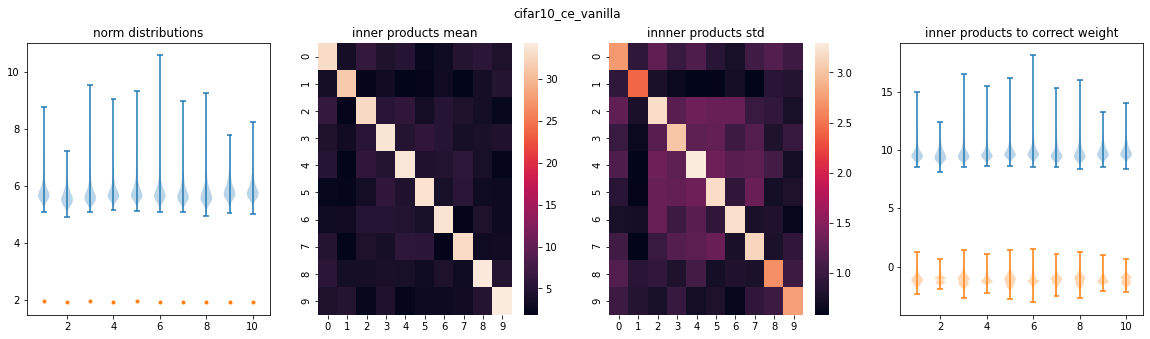

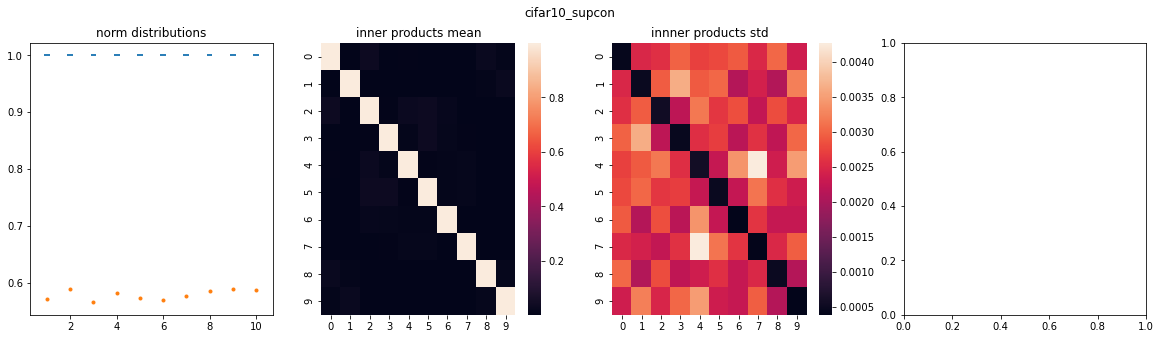

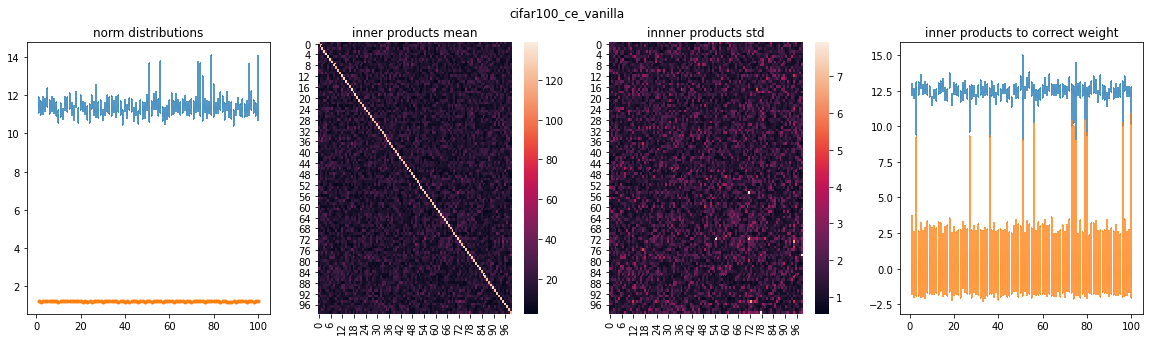

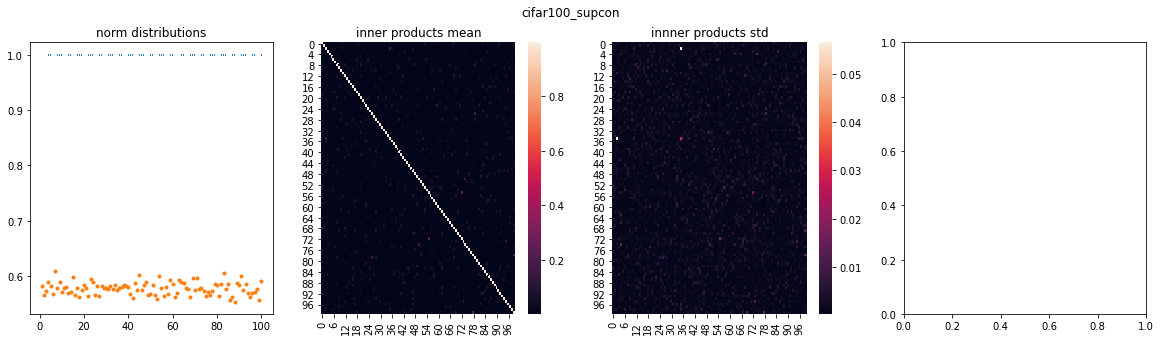

In [105]:
for k in named_results:
    fig, axes = plt.subplots(1, 4, figsize=(4*5, 5))
    fig.suptitle(k)
    
    ln, Y = latent_norms[k]
    Y = torch.tensor(Y)
    labels = sorted(set(Y.tolist()))
    
    axes[0].violinplot([ln[Y == y].numpy() for y in labels])
    axes[0].set_title('norm distributions')
    
    wn = weight_norms[k]
    axes[0].plot(list(range(1, len(labels)+1)), wn.numpy(), '.', label='norms of weights')
    
    prod, YY, norm = latent_geometry[k]
    tmp = {}
    for y_1 in range(len(labels)):
        for y_2 in range(y_1, len(labels)):
            tmp[y_1, y_2] = prod[(YY[:, 0] == y_1) & (YY[:, 1] == y_2)]
            
    mat_mean = torch.zeros((len(labels), len(labels)))
    mat_std = torch.zeros((len(labels), len(labels)))
    
    axes[1].set_title('inner products mean')
    for (y_1, y_2), prods in tmp.items():
        mean = prods.mean().item()
        mat_mean[y_1, y_2] = mean
        mat_mean[y_2, y_1] = mean
        
    sns.heatmap(mat_mean, ax=axes[1])
    
    axes[2].set_title('innner products std')
    for (y_1, y_2), prods in tmp.items():
        std = prods.std().item()
        mat_mean[y_1, y_2] = std
        mat_mean[y_2, y_1] = std
        
    sns.heatmap(mat_mean, ax=axes[2])
    
    if not 'supcon' in k:
    
        axes[3].set_title('inner products to correct weight')
        inprods, Y = latent_innerprod_with_weight[k]

        Y = torch.tensor(Y).long()
        I = torch.zeros_like(inprods, dtype=torch.bool)
        I.scatter_(1, Y.unsqueeze(1), 1)

        inprods_true = inprods[I]
        inprods_true = [inprods_true[Y == y] for y in range(len(labels))]
        axes[3].violinplot(inprods_true)

        inprods_false = inprods[~I].view(-1, len(labels) - 1)
        inprods_false = [inprods_false[Y == y].view(-1) for y in range(len(labels))]
        axes[3].violinplot(inprods_false)
    
    
    